In [3]:
import numpy as np
import cv2

# Generate synthetic video: moving shapes on a dark canvas
H, W, T = 240, 320, 120  # height, width, frames
frames = []

np.random.seed(42)
x, y = 40, 60
vx, vy = 3, 2
radius = 18

for t in range(T):
    frame = np.zeros((H, W, 3), dtype=np.uint8)

    # moving circle
    cv2.circle(frame, (int(x), int(y)), radius, (0, 255, 0), -1)

    # moving rectangle
    rx = int(30 + 60 * np.sin(t / 10.0))
    ry = int(120 + 40 * np.cos(t / 11.0))
    cv2.rectangle(frame, (rx, ry), (rx + 50, ry + 30), (255, 180, 0), -1)

    # update circle position with bouncing
    x += vx; y += vy
    if x - radius < 0 or x + radius >= W: vx *= -1
    if y - radius < 0 or y + radius >= H: vy *= -1

    frames.append(frame)
len(frames)


120

In [4]:
import numpy as np
import cv2

# Motion energy via frame differencing + smoothing
gray = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in frames]
diff = [0.0]  # first frame has no diff
for i in range(1, len(gray)):
    d = cv2.absdiff(gray[i], gray[i-1])
    diff.append(float(d.mean()))

# smooth
k = 5
kernel = np.ones(k) / k
sm = np.convolve(diff, kernel, mode="same")

# adaptive threshold (median + factor * MAD)
med = np.median(sm)
mad = np.median(np.abs(sm - med)) + 1e-6
th = med + 4.0 * mad

# pick keyframes where motion crosses threshold, with non-max suppression
key_idxs = []
cooldown = 6
last = -cooldown
for i in range(len(sm)):
    if sm[i] > th and (i - last) >= cooldown:
        # local maximum in a window
        w = sm[max(0, i-3):min(len(sm), i+4)]
        peak = np.argmax(w) + max(0, i-3)
        key_idxs.append(int(peak))
        last = int(peak)

print("Selected keyframes:", key_idxs[:10], "... total =", len(key_idxs))


Selected keyframes: [] ... total = 0


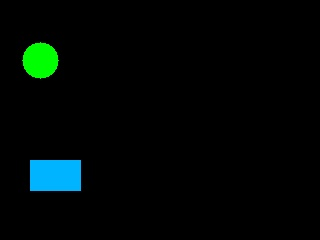

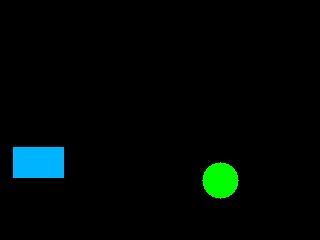

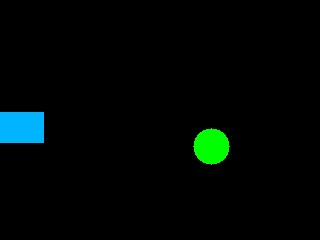

Saved 3 keyframes in ./keyframes


In [6]:
import os, cv2
from IPython.display import Image, display

os.makedirs("keyframes", exist_ok=True)

indices = key_idxs if len(key_idxs) > 0 else [0, len(frames)//2, len(frames)-1]
indices = [i for i in indices if 0 <= i < len(frames)]
indices = sorted(dict.fromkeys(indices))[:6]

saved = 0
for j, idx in enumerate(indices):
    path = os.path.join("keyframes", f"key_{j:02d}_f{idx:04d}.jpg")
    cv2.imwrite(path, frames[idx])
    display(Image(filename=path))
    saved += 1

print(f"Saved {saved} keyframes in ./keyframes")
